In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score ,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import numpy as np


In [ ]:
import pandas as pd

# Load the training data
training_data = pd.read_csv('/content/drive/MyDrive/Train_data.csv')

# Load the test data
test_data = pd.read_csv('/content/drive/MyDrive/test_data.csv')

# Get the columns of each dataset
training_columns = set(training_data.columns)
test_columns = set(test_data.columns)

# Compare columns to find differences
columns_difference = training_columns.symmetric_difference(test_columns)

if len(columns_difference) == 0:
    print("Both datasets have the same columns.")
else:
    print("Columns present only in one dataset:")
    print(columns_difference)

# Check for differences in the number of rows
if training_data.shape[0] == test_data.shape[0]:
    print("Both datasets have the same number of rows.")
else:
    print("The number of rows in the datasets is different.")
    print("Training dataset has {} rows.".format(training_data.shape[0]))
    print("Test dataset has {} rows.".format(test_data.shape[0]))

common_columns = set(training_data.columns).intersection(test_data.columns)

# Initialize a dictionary to store the results of the comparison
column_type_comparison = {}

# Compare the data types of common columns
for col in common_columns:
    training_data_type = training_data[col].dtype
    test_data_type = test_data[col].dtype
    if training_data_type == test_data_type:
        column_type_comparison[col] = "Same"
    else:
        column_type_comparison[col] = "Different"

# Print the comparison results
print("Comparison of data types for columns with the same names:")
for col, comparison_result in column_type_comparison.items():
    print(f"{col}: {comparison_result}")
    # Initialize dictionaries to store the results of the comparison
numeric_comparison = {}
categorical_comparison = {}

# Compare numeric values and categorical ranges for common columns
for col in common_columns:
    training_data_col = training_data[col]
    test_data_col = test_data[col]

    # Compare numeric values (assuming the column is numeric)
    if training_data_col.dtype in ['int64', 'float64']:
        numeric_diff = training_data_col.mean() - test_data_col.mean()  # Calculate the difference in means
        numeric_comparison[col] = abs(numeric_diff) <= 1e-6  # Check if the difference is negligible

    # Compare categories (assuming the column is categorical)
    elif training_data_col.dtype == 'object':
        categorical_diff = set(training_data_col.unique()) == set(test_data_col.unique())  # Check if categories are the same
        categorical_comparison[col] = categorical_diff

# Print the comparison results for numeric values
print("Comparison of numeric values for columns with the same names:")
for col, same_numeric_values in numeric_comparison.items():
    print(f"{col}: {'Same' if same_numeric_values else 'Different'}")

# Print the comparison results for categorical ranges
print("\nComparison of categorical ranges for columns with the same names:")
for col, same_categories in categorical_comparison.items():
    print(f"{col}: {'Same' if same_categories else 'Different'}")

Both datasets have the same columns.
The number of rows in the datasets is different.
Training dataset has 2351 rows.
Test dataset has 486 rows.
Comparison of data types for columns with the same names:
Diastolic Blood Pressure: Same
Cholesterol: Same
Hemoglobin: Same
Platelets: Same
HbA1c: Same
Red Blood Cells: Same
Hematocrit: Same
Mean Corpuscular Hemoglobin: Same
Disease: Same
AST: Same
HDL Cholesterol: Same
Heart Rate: Same
Creatinine: Same
White Blood Cells: Same
LDL Cholesterol: Same
Mean Corpuscular Hemoglobin Concentration: Same
Systolic Blood Pressure: Same
BMI: Same
Triglycerides: Same
ALT: Same
C-reactive Protein: Same
Mean Corpuscular Volume: Same
Glucose: Same
Insulin: Same
Troponin: Same
Comparison of numeric values for columns with the same names:
Diastolic Blood Pressure: Different
Cholesterol: Different
Hemoglobin: Different
Platelets: Different
HbA1c: Different
Red Blood Cells: Different
Hematocrit: Different
Mean Corpuscular Hemoglobin: Different
AST: Different
HDL 

In [ ]:
from sklearn.preprocessing import StandardScaler,LabelEncoder

# Step 1: Standardize numeric values
numeric_columns = training_data.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
training_data[numeric_columns] = scaler.fit_transform(training_data[numeric_columns])
# Check if there are missing values after preprocessing
missing_values = training_data.isnull().sum().sum()
if missing_values == 0:
    print("No missing values after preprocessing.")
else:
    print("Missing values detected after preprocessing. You might need to handle them.")


No missing values after preprocessing.


In [ ]:
training_data.head()

,A,B,C,D
0,-1.322330,1.058652,-1.192662,0.124986
1,1.566352,1.389960,-1.000034,-1.630664
2,-1.624923,-0.611071,1.008388,1.016427
3,0.158136,1.472272,-0.623943,0.018200
4,-0.386429,0.526835,-1.370007,-1.323408


In [ ]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(training_data['Disease'])
training_data.head()

KeyError: 'Disease'

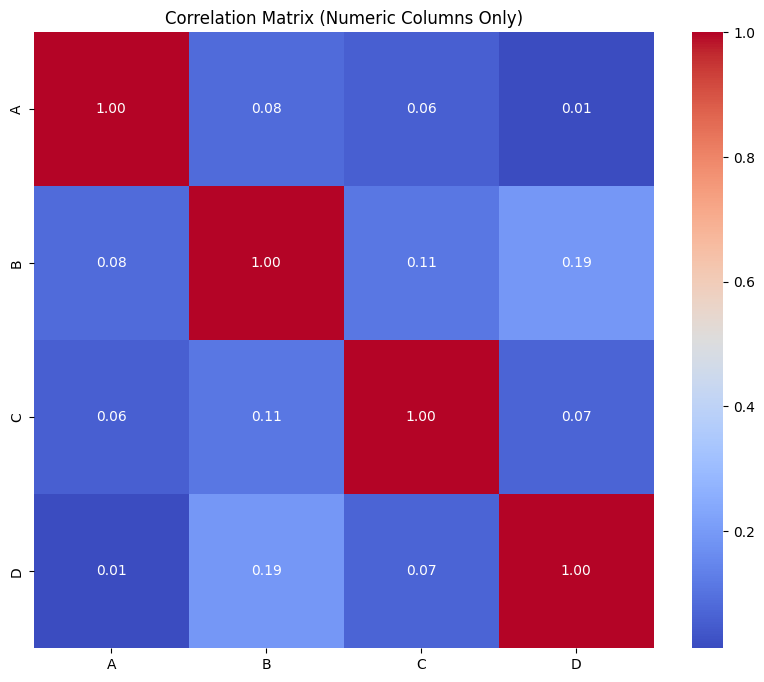

In [ ]:
# Select numeric columns
numeric_columns = training_data.select_dtypes(include=['int64', 'float64']).columns

# Compute the correlation matrix for numeric columns
correlation_matrix = training_data[numeric_columns].corr().abs()

# Create a heatmap to visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()


In [ ]:
# Set a threshold for correlation coefficient
threshold = 0.5

# Get the upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation above the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]


# Drop highly correlated features
training_data_filtered = training_data.drop(to_drop, axis=1)

# Print the dropped columns
print("Dropped columns:", to_drop)


Dropped columns: []


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming your target variable is 'target_column'
X = training_data.drop('Disease', axis=1)
y = training_data['Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of RandomForestClassifier:", accuracy)

from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoostClassifier
ab_classifier = AdaBoostClassifier(random_state=42)

# Train the model
ab_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_ab = ab_classifier.predict(X_test)

# Calculate accuracy
accuracy_ab = accuracy_score(y_test, y_pred_ab)
print("Accuracy of AdaBoostClassifier:", accuracy_ab)
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_classifier = SVC(random_state=42)

# Train the model
svm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM classifier:", accuracy_svm)

from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier()

# Train the model
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_classifier.predict(X_test)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy of KNN classifier:", accuracy_knn)

from sklearn.tree import DecisionTreeClassifier

# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test)

# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy of DecisionTreeClassifier:", accuracy_dt)

from sklearn.ensemble import GradientBoostingClassifier

# Initialize the GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the model
gb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_classifier.predict(X_test)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy of GradientBoostingClassifier:", accuracy_gb)




KeyError: "['Disease'] not found in axis"

In [ ]:

test_data = pd.read_csv('/content/drive/MyDrive/test_data.csv')

numeric_columns = test_data.select_dtypes(include=['int64', 'float64']).columns

# Standardize numeric values in the test data
test_data[numeric_columns] = scaler.transform(test_data[numeric_columns])

# Extract features and target from the preprocessed test data
X_test = test_data.drop('Disease', axis=1)
y_test = test_data['Disease']

# Predict using the trained RandomForestClassifier
y_pred_test = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on svc test:", accuracy_test)



In [ ]:
test_data.head()

In [ ]:
!pip install python-pptx matplotlib seaborn


In [ ]:
!pip install python-pptx


In [ ]:
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to add a title and content slide
def add_title_content_slide(prs, title_text, content_text):
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title, content = slide.shapes.title, slide.placeholders[1]
    title.text = title_text
    title.text_frame.paragraphs[0].font.color.rgb = title_color
    content.text = content_text
    for paragraph in content.text_frame.paragraphs:
        paragraph.font.color.rgb = content_color

# Create a presentation object
prs = Presentation()

# Set a consistent color scheme
title_color = RGBColor(0, 51, 102)  # Dark blue
content_color = RGBColor(0, 0, 0)   # Black

# Title slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Machine Learning Model Comparison and Evaluation"
title.text_frame.paragraphs[0].font.color.rgb = title_color
subtitle.text = "An Analysis of Different Classifiers\nPresented by: [Your Name]"
subtitle.text_frame.paragraphs[0].font.color.rgb = content_color

# Slide 2: Introduction
add_title_content_slide(prs, "Introduction",
    "Objective: To compare the performance of different machine learning classifiers on a given dataset.\n"
    "Dataset: Train and test datasets with information about diseases.\n"
    "Approach: Data preprocessing, analysis, model training, and evaluation.")

# Slide 3: Data Preparation
add_title_content_slide(prs, "Data Preparation",
    "Loading Data: Loaded train and test datasets.\n"
    "Column Comparison: Checked for differences in columns between datasets.\n"
    "Data Types: Ensured columns have the same data types in both datasets.\n"
    "Standardization: Standardized numeric values using StandardScaler.")

# Slide 4: Data Analysis
add_title_content_slide(prs, "Data Analysis",
    "Correlation Matrix: Analyzed correlation between numeric features.\n"
    "Heatmap: Visualized the correlation matrix.\n"
    "Feature Selection: Dropped highly correlated features to avoid multicollinearity.")

# Load your data here
training_data = pd.DataFrame({
    'A': np.random.rand(100),
    'B': np.random.rand(100),
    'C': np.random.rand(100),
    'D': np.random.rand(100)
})
numeric_columns = training_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = training_data[numeric_columns].corr().abs()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric Columns Only)")
heatmap_path = "correlation_matrix_heatmap.png"
plt.savefig(heatmap_path)
plt.close()

# Slide 5: Correlation Matrix Heatmap
slide = prs.slides.add_slide(prs.slide_layouts[5])  # Using slide layout 5 which is for content
title = slide.shapes.title
title.text = "Correlation Matrix Heatmap"
title.text_frame.paragraphs[0].font.color.rgb = title_color

# Add image of heatmap
slide.shapes.add_picture(heatmap_path, Inches(1), Inches(1.5), height=Inches(5.5))

# Slide 6: Model Training and Evaluation
add_title_content_slide(prs, "Model Training and Evaluation",
    "Models Used:\n"
    "- Random Forest Classifier\n"
    "- AdaBoost Classifier\n"
    "- Support Vector Machine (SVM)\n"
    "- K-Nearest Neighbors (KNN)\n"
    "- Decision Tree Classifier\n"
    "- Gradient Boosting Classifier\n"
    "Training and Testing Split: 80% training, 20% testing.\n"
    "Evaluation Metric: Accuracy score.")

# Slide 7: Results - Training Data
add_title_content_slide(prs, "Results - Training Data",
    "RandomForestClassifier: 1.0\n"
    "AdaBoostClassifier: 0.469\n"
    "SVM classifier: 1.0\n"
    "KNN classifier: 1.0\n"
    "DecisionTreeClassifier: 1.0\n"
    "GradientBoostingClassifier: 1.0")

# Slide 8: Results - Test Data
add_title_content_slide(prs, "Results - Test Data", "Best Model (SVM) Accuracy: 0.494")

# Slide 9: Conclusion
add_title_content_slide(prs, "Conclusion",
    "Observations:\n"
    "- High accuracy for most models on training data.\n"
    "- SVM had the best performance on test data.\n"
    "Next Steps:\n"
    "- Further data cleaning and feature engineering.\n"
    "- Hyperparameter tuning for improved performance.\n"
    "- Evaluate models using additional metrics like precision, recall, and F1-score.")

# Slide 10: Q&A
add_title_content_slide(prs, "Q&A", "Questions?\nThank you!")

# Save the presentation
pptx_path = "ML_Model_Comparison_Presentation.pptx"
prs.save(pptx_path)

print(f"Presentation saved as {pptx_path}")
